In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth' ,999)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score, mean_squared_error, accuracy_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

np.random.seed(3792)

In [9]:
kickoff_df = pd.read_csv('../data/kickoff_no_nulls.csv')
kickoff_df.drop(columns ='Unnamed: 0', inplace=True)
kickoff_df.head(1)

,gameId,playId,playDescription,quarter,possessionTeam,kickerId,returnerId,yardlineSide,yardlineNumber,gameClock,penaltyCodes,penaltyJerseyNumbers,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,absoluteYardlineNumber,hangTime,kickType,kickDirectionIntended,kickDirectionActual,returnDirectionIntended,returnDirectionActual,missedTackler,assistTackler,tackler,kickoffReturnFormation,specialTeamsSafeties
0,2018090600,677,"M.Bosher kicks 64 yards from ATL 35 to PHI 1. S.Gibson to PHI 31 for 30 yards (D.Kazee, D.Riley).",1,ATL,37267.0,44979,ATL,35,05:01:00,NP,NP,0,0,3,64.0,30.0,75,4.06,D,R,R,C,C,ATL 83,ATL 22,ATL 27,8-0-2,ATL 17; ATL 22


## Linear Regression 
Running a simple Linear Regression to check the complexity of the current data

In [10]:
numerics = ['uint8', 'float64', 'int64', 'int32', 'float16', 'float32']

kickoff_numerics = kickoff_df.select_dtypes(include=numerics)
kickoff_numerics.head()

,gameId,playId,quarter,kickerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,absoluteYardlineNumber,hangTime
0,2018090600,677,1,37267.0,35,0,0,3,64.0,30.0,75,4.06
1,2018090600,1606,2,37267.0,35,5,3,6,68.0,13.0,45,3.63
2,2018090900,36,1,33469.0,35,0,0,0,69.0,24.0,75,3.83
3,2018090900,400,1,39470.0,35,0,7,0,61.0,28.0,45,4.21
4,2018090900,1992,2,39470.0,35,0,20,0,65.0,25.0,75,3.99


In [4]:
X = kickoff_numerics.drop(columns='kickReturnYardage')
y = kickoff_numerics['kickReturnYardage']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=3792,
                                                   train_size=.75)

In [5]:
lr = LinearRegression()

In [6]:
lr.fit(X_train, y_train)

LinearRegression()

In [7]:
lr.score(X_train, y_train) , lr.score(X_test, y_test)

(0.16735258276269638, 0.13094927683547275)

In [8]:
lr.coef_[2]

1.6204470736997851

In [9]:
pd.DataFrame(zip( X.columns, lr.coef_), 
             columns=['Feature', 'Coef'])

,Feature,Coef
0,gameId,-1.766379e-07
1,playId,-1.036489e-03
2,quarter,1.620447e+00
3,kickerId,-1.564126e-04
4,yardlineNumber,1.356343e-01
5,penaltyYards,-2.819545e-01
6,preSnapHomeScore,-4.391865e-02
7,preSnapVisitorScore,-4.008917e-02
8,kickLength,7.159659e-01
9,absoluteYardlineNumber,-1.022048e-02


In [10]:
round((mean_squared_error(y_true=y_test, y_pred=lr.predict(X_test)) ** .5), 4)

9.1482

### Interpretation
* I ran a simple Linear Regression to see if I have enough information or complexity in the dataset. Results seem to indicate that I probably need to add in more data from the other files and likely need to look at tracking data. 
* All that said lets look at a simple binary Logistic Regression as well to further check the complexity

## Logisitc Regression
* Setting a successful return as a kick return that gains 25 or more yards.

In [11]:
kickoff_numerics['kickReturnYardage'] = kickoff_numerics.kickReturnYardage.map(lambda kickReturnYardage : 1 if kickReturnYardage >= 25 else 0)
kickoff_numerics.head()

<ipython-input-11-79cb8c66a3e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kickoff_numerics['kickReturnYardage'] = kickoff_numerics.kickReturnYardage.map(lambda kickReturnYardage : 1 if kickReturnYardage >= 25 else 0)


,gameId,playId,quarter,kickerId,yardlineNumber,penaltyYards,preSnapHomeScore,preSnapVisitorScore,kickLength,kickReturnYardage,absoluteYardlineNumber,hangTime
0,2018090600,677,1,37267.0,35,0,0,3,64.0,1,75,4.06
1,2018090600,1606,2,37267.0,35,5,3,6,68.0,0,45,3.63
2,2018090900,36,1,33469.0,35,0,0,0,69.0,0,75,3.83
3,2018090900,400,1,39470.0,35,0,7,0,61.0,1,45,4.21
4,2018090900,1992,2,39470.0,35,0,20,0,65.0,1,75,3.99


In [12]:
#baseline 
kickoff_numerics['kickReturnYardage'].value_counts(normalize=True)

0    0.654428
1    0.345572
Name: kickReturnYardage, dtype: float64

So our Baseline model would predict an unsuccessful kickoff return on ~70% of our returns.

In [13]:
#Train test split to .8 to .2 due to the smaller data set, I want to give the training set as much to train on
X = kickoff_numerics.drop(columns='kickReturnYardage')
y = kickoff_numerics['kickReturnYardage']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=3792,
                                                   train_size= .8,
                                                   stratify= y)

In [14]:
y_train.value_counts() , y_train.value_counts(normalize=True)

(0    1383
 1     730
 Name: kickReturnYardage, dtype: int64,
 0    0.65452
 1    0.34548
 Name: kickReturnYardage, dtype: float64)

In [15]:
y_test.value_counts() , y_test.value_counts(normalize=True)

(0    346
 1    183
 Name: kickReturnYardage, dtype: int64,
 0    0.654064
 1    0.345936
 Name: kickReturnYardage, dtype: float64)

Distribution of successful : not is essentially the same for train and test.

In [16]:
log_reg = LogisticRegression()
log_reg.fit(X=X_train, y=y_train)

LogisticRegression()

In [17]:
round(log_reg.score(X_train, y_train), 4)

0.6545

In [18]:
round(log_reg.score(X_test, y_test), 4)

0.6541

In [19]:
f1_score(y_true=y_test, y_pred= log_reg.predict(X_test))

0.0

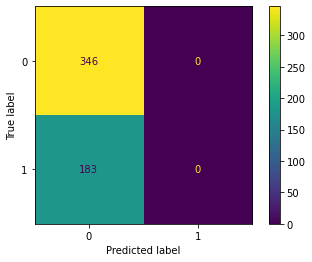

In [21]:
plot_confusion_matrix(estimator=log_reg,
                      X=X_test, 
                      y_true=y_test)
plt.savefig('../images/simple_logreg_conf_matrix.png', bbox_inches = 'tight');

### Simple Log Reg Interpretation
We have a number of problems with our current model:
1. Our biggest issue is that WE AREN'T PREDICTING our positive class at all!
1. Our train and test scores are nearly identical so we can definitely add in more complexity.